In [3]:
!pip install -q wfdb
!pip install -q transformers

In [4]:
import wfdb
import numpy as np
import pandas as pd
import scipy as sp
from scipy import io as sio
from scipy import signal as sps
import matplotlib.pyplot as plt


from bisect import bisect
from collections import defaultdict
import pickle
import json

## Load Data

In [5]:
patient_ids = [100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,123,124,200,201,202,203,205,207,208,209,210,212,213,214,215,217,219,220,221,222,223,228,230,231,232,233,234]

### Read the ECG signals and some information about them. This loads the 2-leads into the corresponding variables.

In [6]:
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(str(id_), pn_dir='mitdb')
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
    return lead0, lead1

In [7]:
lead0, lead1 = get_ecg_signals(patient_ids)

In [8]:
lead0, lead1

({100: array([-0.145, -0.145, -0.145, ..., -0.675, -0.765, -1.28 ]),
  101: array([-0.345, -0.345, -0.345, ..., -0.295, -0.29 ,  0.   ]),
  102: array([-0.2  , -0.2  , -0.2  , ..., -0.17 , -0.195,  0.   ]),
  103: array([-0.375, -0.375, -0.375, ..., -0.235, -0.245,  0.   ]),
  104: array([-0.15 , -0.15 , -0.15 , ..., -0.065, -0.06 ,  0.   ]),
  105: array([-0.445, -0.445, -0.445, ...,  0.59 ,  0.76 ,  1.28 ]),
  106: array([-0.31 , -0.31 , -0.31 , ...,  0.635,  0.265,  0.   ]),
  107: array([-2.045, -2.045, -2.045, ..., -0.645, -0.635,  0.   ]),
  108: array([-0.125, -0.125, -0.125, ..., -0.01 ,  0.04 ,  0.   ]),
  109: array([ 0.175,  0.175,  0.175, ..., -0.92 , -0.91 , -1.28 ]),
  111: array([-0.035, -0.035, -0.035, ...,  0.155,  0.2  ,  0.   ]),
  112: array([-0.75 , -0.75 , -0.75 , ..., -0.825, -0.81 , -1.28 ]),
  113: array([-0.46, -0.46, -0.46, ...,  1.06,  0.42,  0.  ]),
  114: array([-0.045, -0.045, -0.045, ..., -0.365, -0.37 ,  0.   ]),
  115: array([-0.58, -0.58, -0.58, ..., 

In [9]:
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp( str(patient_ids[0]), pn_dir='mitdb')
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [10]:
ecg_info = get_ecg_info(patient_ids)
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

### Annotations contain peak locations, and their labels (N, V, S, etc.).
- **annotation.sample contains the indices**
- **annotation.symbol contains the labels**
- **use help(wfdb.Record), help(wfdb.Annotation) for more info** **bold text**

In [11]:
def get_paced_patients(patient_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(str(id_), pn_dir='mitdb', extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)

In [12]:
paced_patients = get_paced_patients(patient_ids)
paced_patients

array([102, 104, 107, 217])

In [13]:
def get_all_beat_labels(patient_ids):
    all_labels = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(str(id_), pn_dir='mitdb', extension='atr')
        labels = np.unique(annotation.symbol)
        all_labels.extend(labels)
    return np.unique(all_labels)

In [14]:
all_beat_labels = get_all_beat_labels(patient_ids)
all_beat_labels

array(['!', '"', '+', '/', 'A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S',
       'V', '[', ']', 'a', 'e', 'f', 'j', 'x', '|', '~'], dtype='<U1')

In [15]:
def get_rpeaks_and_labels(patient_ids):
    rpeaks = {}
    labels = {}
    for id_ in patient_ids:
        annotation = wfdb.rdann(str(id_), pn_dir='mitdb', extension='atr')
        rpeaks[id_] = annotation.sample
        labels[id_] = np.array(annotation.symbol)
    return rpeaks, labels

In [16]:
rpeaks, labels = get_rpeaks_and_labels(patient_ids)
rpeaks, labels

({100: array([    18,     77,    370, ..., 649484, 649734, 649991]),
  101: array([     7,     83,    396, ..., 649004, 649372, 649751]),
  102: array([    68,    136,    410, ..., 649244, 649553, 649852]),
  103: array([    21,    265,    575, ..., 649195, 649534, 649875]),
  104: array([    36,     73,    316, ..., 649300, 649580, 649876]),
  105: array([    67,    197,    459, ..., 649221, 649471, 649740]),
  106: array([    83,    229,    351, ..., 649162, 649340, 649791]),
  107: array([    47,     95,    272, ..., 649129, 649441, 649748]),
  108: array([    23,     88,    442, ..., 649170, 649471, 649769]),
  109: array([    18,    111,    343, ..., 649378, 649663, 649931]),
  111: array([    31,    197,    489, ..., 649148, 649441, 649724]),
  112: array([    15,    124,    382, ..., 649361, 649626, 649883]),
  113: array([    22,    170,    583, ..., 649364, 649675, 649994]),
  114: array([    21,    310,    726, ..., 649261, 649523, 649783]),
  115: array([    44,    161,    5

### Visualize and plot.
- **Decide how many seconds to plot.**
- **Plot the peaks up-to that point.**

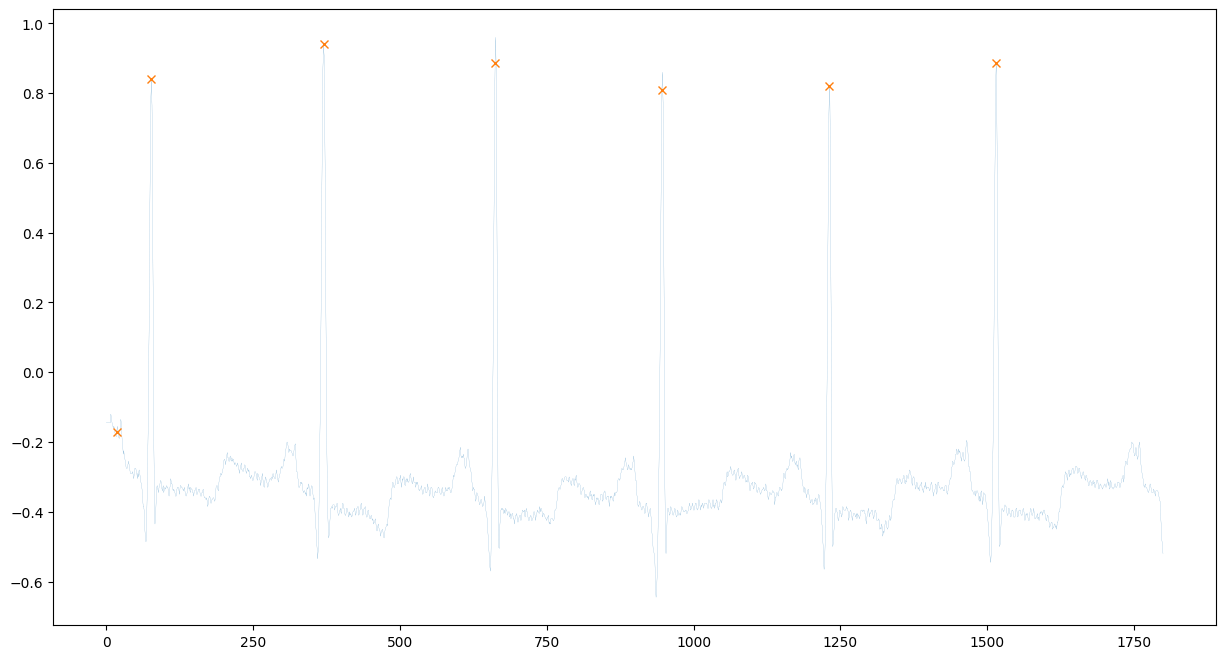

In [17]:
patient_id = 100
secs = 5
samps = secs * ecg_info["fs"]
upto = bisect(rpeaks[patient_id], samps)
signal, peaks = lead0[patient_id], rpeaks[patient_id]

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(signal[:samps], linewidth=0.1)
plt.plot(peaks[:upto], signal[peaks[:upto]], marker="x", linestyle="")
plt.show()

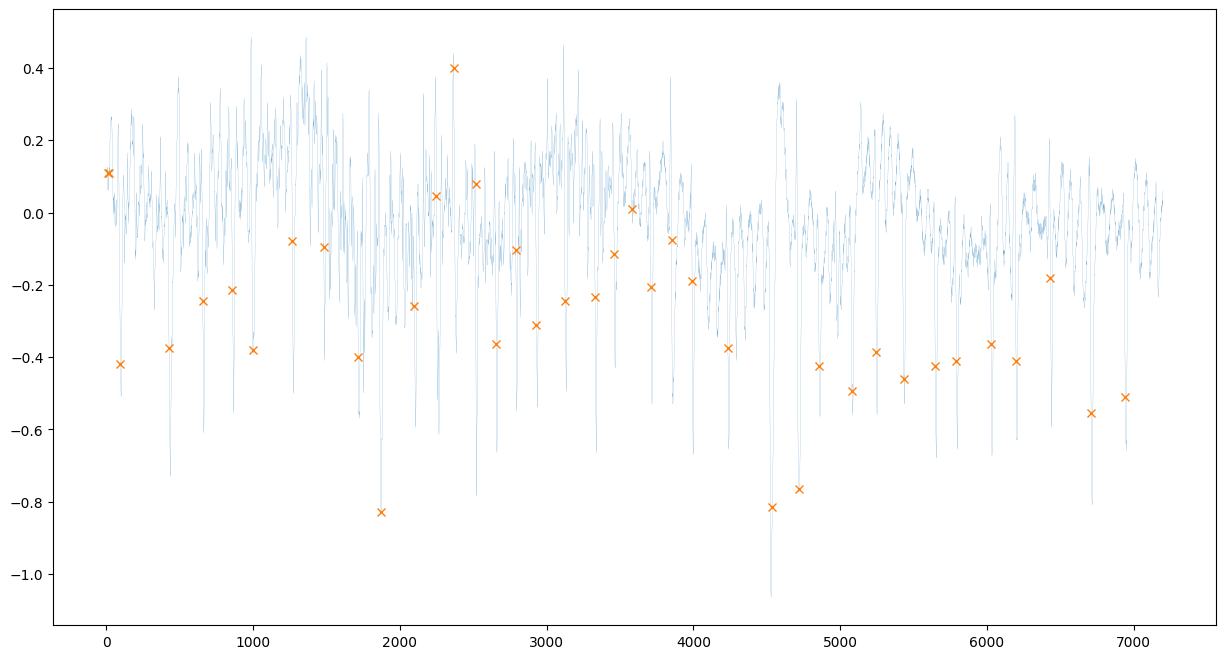

In [18]:
patient_id = 203
secs = 20
samps = secs * ecg_info["fs"]
upto = bisect(rpeaks[patient_id], samps)
signal, peaks = lead1[patient_id], rpeaks[patient_id]

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(signal[:samps], linewidth=0.1)
plt.plot(peaks[:upto]-2, signal[peaks[:upto]-2], marker="x", linestyle="")
plt.show()

### Separate ECG signal into its beats and annotate them.
- **We only capture beats that are annotated in one of the classes given in the functions below.**
- **We don't capture the left-most and right-most beats.**
- **Beat classes are different from beat labels. Classes are only one of N, S, V, F, Q.**
https://physionet.org/physiobank/database/html/mitdbdir/intro.htm
https://archive.physionet.org/physiobank/database/html/mitdbdir/tables.htm


In [19]:
def get_normal_beat_labels():
    """
    The MIT-BIH labels that are classified as healthy/normal. Check wfdb.Annotation documentation for description of labels.
    N: {N, L, R, e, j}. 
    """
    return np.array(["N", "L", "R", "e", "j"])

def get_abnormal_beat_labels():
    """
    The MIT-BIH labels that are classified as arrhythmia/abnormal. Check wfdb.Annotation documentation for description of labels.
    S: {S, A, J, a} - V: {V, E} - F: {F} - Q: {Q}
    """
    return np.array(["S", "A", "J", "a", "V", "E", "F", "Q"])

def get_beat_class(label):
    """
    A mapping from labels to classes, based on the rules described in get_normal_beat_labels() and get_abnormal_beat_labels().
    """
    if label in ["N", "L", "R", "e", "j"]:
        return "N"
    elif label in ["S", "A", "J", "a"]:
        return "S"
    elif label in ["V", "E"]:
        return "V"
    elif label == "F" or label == "Q":
        return label
    return None

In [20]:
def get_beats(patient_ids, signals, rpeaks, labels, beat_trio=False, centered=False, lr_offset=0.1, matlab=False):
    """
    For each patient:
    Converts its ECG signal to an array of valid beats, where each rpeak with a valid label is converted to a beat of length 128 by resampling (Fourier-Domain).
    Converts its labels to an array of valid labels, and a valid label is defined in the functions get_normal_beat_labels() and get_abnormal_beat_labels().
    Converts its valid labels to an array of classes, where each valid label is one of 5 classes, (N, S, V, F, Q).

    Parameters
    ----------
    beat_trio: bool, default=False
        If True, generate beats as trios.

    centered: bool, default=False
        Whether the generated beats have their peaks centered.

    lr_offset: float, default=0.1, range=[0, 1]
        A beat is extracted by finding the beats before and after it, and then offsetting by some samples. This parameter controls how many samples are
        offsetted. If the lower beat is L, and the current beat is C, then we offset by `lr_offset * abs(L - C)` samples.

    matlab: bool, default=False
        If True, dictionary keys become strings to be able to save the dictionary as a .mat file.
    """
    
    beat_length = 128
    get_key_name = lambda patient_id: f"patient_{patient_id}" if matlab else patient_id
    
    beat_data = {get_key_name(patient_id):{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
    
    for j, patient_id in enumerate(patient_ids):
        key_name = get_key_name(patient_id)
        
        # Filter out rpeaks that do not correspond to a valid label.
        valid_labels = np.concatenate((get_normal_beat_labels(), get_abnormal_beat_labels()))
        valid_idx = np.where(np.isin(labels[patient_id], valid_labels))[0]
        valid_rpeaks = rpeaks[patient_id][valid_idx]
        valid_labels = labels[patient_id][valid_idx]
        
        for i in range(1, len(valid_rpeaks) - 1):
            lpeak = valid_rpeaks[i - 1]
            cpeak = valid_rpeaks[i]
            upeak = valid_rpeaks[i + 1]
    
            if beat_trio:
                lpeak = int(lpeak - (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak + (lr_offset * abs(cpeak - upeak)))
            else:
                lpeak = int(lpeak + (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak - (lr_offset * abs(cpeak - upeak)))
            
            if centered:
                ldiff = abs(lpeak - cpeak)
                udiff = abs(upeak - cpeak)
                diff = min(ldiff, udiff)
                
                # Take same number of samples from the center.
                beat = signals[patient_id][cpeak - diff:cpeak + diff + 1]
            else:
                beat = signals[patient_id][lpeak:upeak]
            
            # Resampling in the frequency domain instead of in the time domain (resample_poly)
            # beat = sp.signal.resample_poly(beat, beat_length, len(beat))
            beat = sp.signal.resample(beat, beat_length)
    
            # detrend the beat and normalize it.
            beat = sps.detrend(beat)
            beat = beat / np.linalg.norm(beat, ord=2)
        
            label = valid_labels[i]
        
            beat_data[key_name]["beats"].append(beat)
            beat_data[key_name]["class"].append(get_beat_class(label))
            beat_data[key_name]["label"].append(label)
        beat_data[key_name]["beats"] = np.stack(beat_data[key_name]["beats"])
        beat_data[key_name]["class"] = np.stack(beat_data[key_name]["class"])
        beat_data[key_name]["label"] = np.stack(beat_data[key_name]["label"])
        
    return beat_data

In [21]:
beat_data = get_beats(patient_ids, lead0, rpeaks, labels, beat_trio=False, centered=False, lr_offset=0.1)

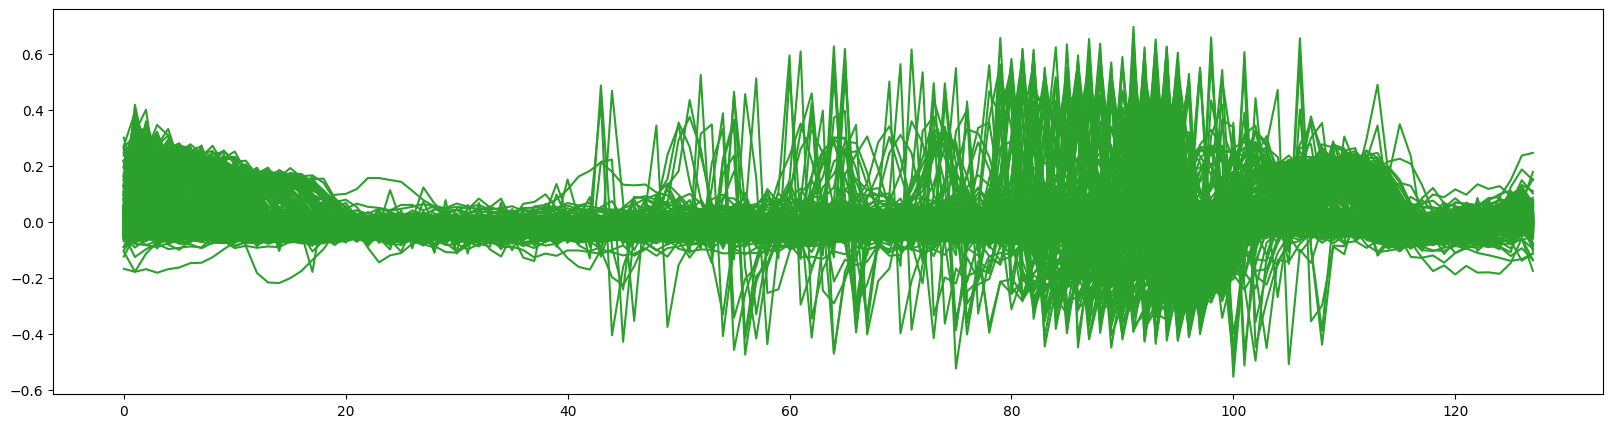

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(beat_data[232]["beats"][beat_data[232]["class"] == "N"].T, "C2")
plt.show()

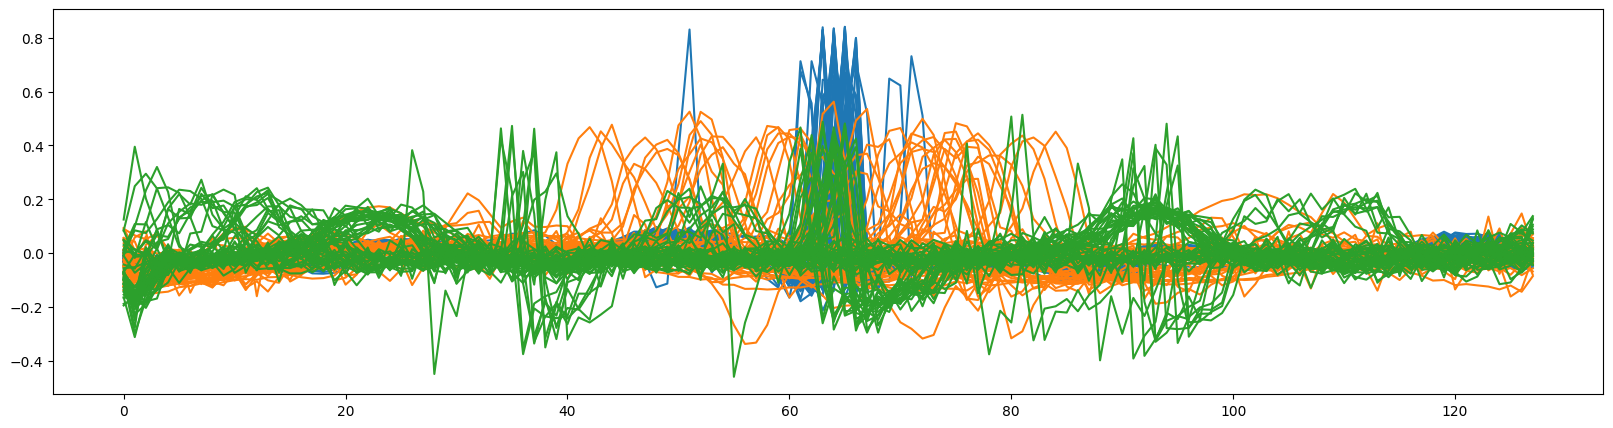

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(beat_data[100]["beats"][0:50].T, "C0")
plt.plot(beat_data[203]["beats"][0:50].T, "C1")
plt.plot(beat_data[232]["beats"][0:50].T, "C2")
plt.show()

### Find the sample that corresponds to the 5 minute mark, and take the healthy signals before it.
### Careful:
- **We skipped the first beat (because there is no beat to its left).**
- **When we say `idx = bisect(rpeaks[patient_id], fivemin)`, we get the index of the beat that is the first beat after 5 minutes has passed.**
- **But since the first beat is skipped, that index is actually the second beat after 5 minutes has passed in our data.**
- **We should say `idx = bisect(rpeaks[patient_id], fivemin) - 1` to get the correct index.**

In [24]:
beat_data[100]

{'beats': array([[-0.03024875, -0.00817779, -0.01984587, ...,  0.033241  ,
          0.00027685, -0.01480269],
        [-0.01822005, -0.01540304, -0.02438463, ..., -0.03207176,
         -0.03768637, -0.0433033 ],
        [-0.01165083, -0.03115363, -0.02595843, ..., -0.02640448,
         -0.02916875, -0.03896504],
        ...,
        [-0.03968485, -0.03872239, -0.03920411, ..., -0.03969629,
         -0.03516211, -0.0505896 ],
        [-0.03610631, -0.04026123, -0.03522159, ..., -0.05704345,
         -0.05580564, -0.05910287],
        [-0.09061379, -0.04489519, -0.04724623, ..., -0.07697315,
         -0.04605489, -0.07292854]]),
 'class': array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1'),
 'label': array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')}

## Train


### Pytorch with BERT

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [26]:
class HeartRateDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        beats = self.data[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            beats,
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"][0],
            "attention_mask": encoding["attention_mask"][0],
            "label": torch.tensor(int(label)),
        }

In [27]:
class HeartRateClassifier(nn.Module):
    def __init__(self, num_labels):
        super(HeartRateClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs["pooler_output"]
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits

In [28]:
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, total_correct = 0, 0
    
    progress_bar = tqdm(dataloader, desc="Training", unit="batch")
    
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()
        progress_bar.set_postfix({"Loss": total_loss / (total_correct if total_correct != 0 else 1)})
    
    acc = total_correct / len(dataloader.dataset)
    return total_loss, acc

In [29]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    
    progress_bar = tqdm(dataloader, desc="Evaluating", unit="batch")
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            total_correct += torch.sum(preds == labels).item()
            progress_bar.set_postfix({"Loss": total_loss / (total_correct if total_correct != 0 else 1)})
    
    acc = total_correct / len(dataloader.dataset)
    return total_loss, acc

In [30]:
# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [100]:
def load_checkpoint(filename, model, optimizer=None):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    return epoch

In [99]:
def evaluate(model, dataloader, device):
    model.eval()
    model.to(device)
    total_correct = 0
    
    progress_bar = tqdm(dataloader, desc="Evaluating", unit="batch")
    
    with torch.no_grad():
        batch_num = 1
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            total_correct += torch.sum(preds == labels).item()
            progress_bar.set_postfix({"accracy": (total_correct if total_correct != 0 else 1) / (batch_num*16)})
            batch_num += 1
    
    acc = total_correct / len(dataloader.dataset)
    return acc

### Load Data

In [31]:
# # Load the dataset from csv file
# data = pd.read_csv('data.csv')
# data.drop('label', axis=1, inplace=True)
# data.rename(columns={'class': 'label'}, inplace=True)
# data['label'] = data['label'].apply(lambda x: 0 if x == 'N' else 1)

# #Split the data into training and testing sets
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# #Convert numerical data to strings
# train_beats = [','.join(map(str, np.fromstring(x, sep=','))) for x in train_data['beat'].tolist()]
# train_labels = train_data['label'].tolist()

# test_beats = [','.join(map(str, np.fromstring(x, sep=','))) for x in test_data['beat'].tolist()]
# test_labels = test_data['label'].tolist()

In [32]:
data = pd.DataFrame(columns=["beat", "label","id"])
for i in patient_ids: 
  df = pd.DataFrame(zip(beat_data[i]['beats'], beat_data[i]['class']), columns=["beat", "label"])
  df["id"] = i
  data = pd.concat([data, df], ignore_index=True)

In [33]:
data['label'] = data['label'].apply(lambda x: 0 if x == 'N' else 1)

In [34]:
#Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Trained with Pre-Trained BERT

In [35]:
#Convert numerical data to strings
train_beats = [','.join(map(str, x)) for x in train_data['beat'].tolist()]
train_labels = train_data['label'].tolist()

test_beats = [','.join(map(str, x)) for x in test_data['beat'].tolist()]
test_labels = test_data['label'].tolist()

In [38]:
#Create datasets
train_dataset = HeartRateDataset(train_beats, train_labels)
test_dataset = HeartRateDataset(test_beats, test_labels)

#Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HeartRateClassifier(num_labels=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Train and evaluate the model with checkpoint saving
epochs = 10
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

In [ ]:
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    eval_loss, eval_acc = evaluate(model, test_loader, loss_fn, device)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}, Training Accuracy: {train_acc:.2f}, Validation Loss: {eval_loss/len(test_loader)}, Validation Accuracy: {eval_acc:.2f}")

    # Save the checkpoint after each epoch
    checkpoint_file = f"{checkpoint_dir}/model_epoch_{epoch+1}.pt"
    save_checkpoint(model, optimizer, epoch, checkpoint_file)

Training:   0%|          | 0/5070 [00:00<?, ?batch/s]

In [ ]:
from transformers import BertTokenizer

CHECKPOINT_FILE = "checkpoints/model_epoch_1.pt"

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = HeartRateClassifier(num_labels=2)
epoch = load_checkpoint(CHECKPOINT_FILE, model)
eval_acc = evaluate(model, test_loader, device)
print(f"Validation Accuracy: {eval_acc:.2f}")

### Train with Random Forest

In [93]:
train_beats_numerical = train_data['beat'].to_list()
train_labels = train_data['label'].to_list()

test_beats_numerical = test_data['beat'].to_list()
test_labels = test_data['label'].to_list()

In [95]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_beats_numerical, train_labels)
y_pred = rf.predict(test_beats_numerical)

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(test_labels, y_pred))
print("Precision:", precision_score(test_labels, y_pred, average='macro'))
print("Recall:", recall_score(test_labels, y_pred, average='macro'))
print("F1 score:", f1_score(test_labels, y_pred, average='macro'))

Accuracy: 0.9845152381891705
Precision: 0.9834132918204657
Recall: 0.933672684858976
F1 score: 0.9568010848692545
